In [35]:

import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Set random seed & device
# -----------------------------------------------------------------------------

torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda


In [45]:
# -----------------------------------------------------------------------------
# Problem constants & helper functions
# -----------------------------------------------------------------------------

a = 1/1.2  # advection speed

# Network architecture: input (x,t) -> 64‑64‑64 hidden units -> output u
layers = [2, 128, 128,128,128,128, 1]


class PINN(nn.Module):
    """Simple fully‑connected network with tanh activations."""

    def __init__(self, layers):
        super().__init__()
        blocks = []
        for l_in, l_out in zip(layers[:-2], layers[1:-1]):
            blocks.append(nn.Linear(l_in, l_out))
            blocks.append(nn.Tanh())
        blocks.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*blocks)

        # Xavier (Glorot) initialisation for faster convergence
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        """x, t: tensors of shape (N,1)"""
        input_pair = torch.cat([x, t], dim=1)
        return self.model(input_pair)


def pde_residual(model: nn.Module, x: torch.Tensor, t: torch.Tensor):
    """Compute residual f(x,t) = ∂u/∂t + a ∂u/∂x."""
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)

    # ∂u/∂t
    u_t = autograd.grad(u, t,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True)[0]
    # ∂u/∂x
    u_x = autograd.grad(u, x,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True)[0]

    return u_t + a * u_x  # residual should be ≈ 0

In [ ]:

def get_density(t):
    """
    Returns the density (as a PyTorch tensor) based on time t (in seconds).
    Supports scalar or batch tensor input.
    
    Parameters:
        t (torch.Tensor): Time(s) in seconds.
        
    Returns:
        torch.Tensor: Density (kg/m³), same shape as t.
    """
    t = torch.as_tensor(t, dtype=torch.float32)
    cycle_position = torch.floor(t / 60).to(torch.int32)
    
    # Even cycles → water (1000), Odd cycles → phosphate (1800)
    density = torch.where(cycle_position % 2 == 0,
                          torch.tensor(1),
                          torch.tensor(1.6))
    return density



def get_viscosity(t):
    """
    Returns the density (as a PyTorch tensor) based on time t (in seconds).
    Supports scalar or batch tensor input.
    
    Parameters:
        t (torch.Tensor): Time(s) in seconds.
        
    Returns:
        torch.Tensor: Density (kg/m³), same shape as t.
    """
    t = torch.as_tensor(t, dtype=torch.float32)
    cycle_position = torch.floor(t / 60).to(torch.int32)
    
    Mu = torch.where(cycle_position % 2 == 0,
                          torch.tensor(0.01),
                          torch.tensor(1))
    return Mu
    # return Mu


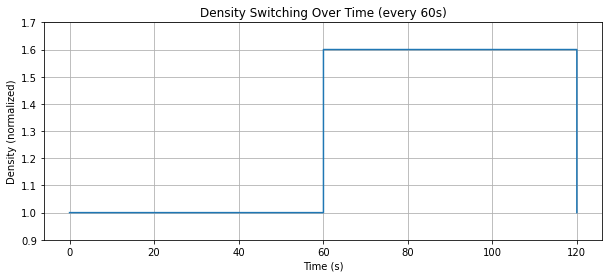

In [63]:
# Generate time values from 0 to 600 seconds
t_values = torch.linspace(0, 120, steps=1000)
density_values = get_density(t_values)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t_values, density_values, drawstyle='steps-post')
plt.xlabel("Time (s)")
plt.ylabel("Density (normalized)")
plt.title("Density Switching Over Time (every 60s)")
plt.grid(True)
plt.ylim(0.9, 1.7)
plt.show()

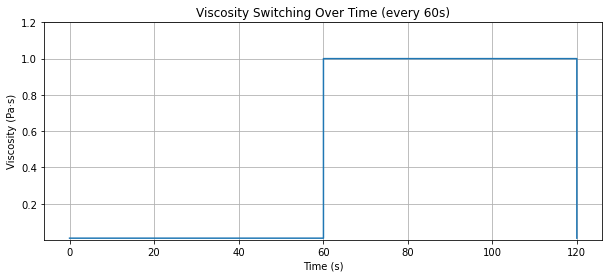

In [64]:
# Generate time values from 0 to 600 seconds
t_values = torch.linspace(0, 120, steps=1000)
vi_values = get_viscosity(t_values)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t_values, vi_values, drawstyle='steps-post')
plt.xlabel("Time (s)")
plt.ylabel("Viscosity (Pa·s)")
plt.title("Viscosity Switching Over Time (every 60s)")
plt.grid(True)
plt.ylim(1e-3, 1.2)
plt.show()

In [80]:
# -----------------------------------------------------------------------------
# Training data (collocation + IC + BC)
# -----------------------------------------------------------------------------
T_final = 120  # seconds
# Pipe length (m)
Pipe_lenth = 100

N_f = 1000000 # interior collocation points
N_i = 50000     # initial‑condition points
N_b = 50000    # boundary‑condition points

Pipe_diameter = 0.85  # m

# Interior points: (x,t) uniformly sampled in [0, L] x [0, T]
x_f = Pipe_lenth*torch.rand( N_f, 1, device=device, dtype=torch.float32)
t_f = T_final*torch.rand(N_f,1, device=device)     # <--- scaled by T_final

# Initial condition: t = 0
x_i = torch.rand(N_i, 1, device=device)
t_i = torch.zeros_like(x_i)
Rho_i = 1
Mu_i = 0.01
P_i = 1
# Boundary condition: x = 0
x_b = torch.zeros(N_b, 1, device=device)
t_b = T_final*torch.rand(N_b, 1, device=device)
Rho_b = get_density(t_b)
Mu_b = get_viscosity(t_b)
P_b = 1

In [49]:
# -----------------------------------------------------------------------------
# Model & optimisers
# -----------------------------------------------------------------------------
Rho = PINN(layers).to(device)
opt_adam = torch.optim.Adam(Rho.parameters(), lr=1e-3)
opt_lbfgs = torch.optim.LBFGS(Rho.parameters(),
                              lr=1.0,
                              max_iter=1000,
                              tolerance_grad=1e-9,
                              tolerance_change=1e-9,
                              history_size=100,
                              line_search_fn="strong_wolfe")


In [50]:
def loss_components():
    """Returns individual MSE losses: residual, IC, BC."""
    f = pde_residual(Rho, x_f, t_f)
    rho_pred_i = Rho(x_i, t_i)
    rho_pred_b = Rho(x_b, t_b)

    loss_f = torch.mean(f ** 2)
    loss_i = torch.mean((rho_pred_i - Rho_i) ** 2)
    loss_b = torch.mean((rho_pred_b - Rho_b) ** 2)
    
    return loss_f, loss_i, loss_b

In [52]:
# -----------------------------------------------------------------------------
# Stage 1 – Adam optimisation
# -----------------------------------------------------------------------------

epochs = 8000

for ep in range(epochs):
    opt_adam.zero_grad()
    lf, li, lb = loss_components()
    loss = lf + li + lb
    loss.backward()
    opt_adam.step()

    if ep % 500 == 0:
        print(f"Adam  {ep:4d}: total={loss.item():.3e}  "
              f"(res={lf.item():.1e}, IC={li.item():.1e}, BC={lb.item():.1e})")

# -----------------------------------------------------------------------------
# Stage 2 – L‑BFGS fine‑tuning
# -----------------------------------------------------------------------------

print("Starting L‑BFGS …")

def closure():
    opt_lbfgs.zero_grad()
    lf, li, lb = loss_components()
    loss = lf + li + lb
    loss.backward()
    return loss

opt_lbfgs.step(closure)
print("L‑BFGS complete.")


Adam     0: total=1.625e-02  (res=1.4e-04, IC=2.0e-05, BC=1.6e-02)
Adam   500: total=8.545e-03  (res=9.2e-05, IC=7.3e-06, BC=8.4e-03)
Adam  1000: total=1.823e-03  (res=8.6e-05, IC=2.1e-06, BC=1.7e-03)
Adam  1500: total=1.274e-03  (res=5.2e-05, IC=9.6e-06, BC=1.2e-03)
Adam  2000: total=9.772e-04  (res=2.7e-05, IC=3.2e-06, BC=9.5e-04)
Adam  2500: total=2.173e-03  (res=1.7e-05, IC=1.0e-04, BC=2.1e-03)
Adam  3000: total=2.634e-03  (res=1.2e-05, IC=1.6e-04, BC=2.5e-03)
Adam  3500: total=7.803e-04  (res=8.8e-06, IC=1.3e-05, BC=7.6e-04)
Adam  4000: total=8.308e-04  (res=7.0e-06, IC=3.5e-05, BC=7.9e-04)
Adam  4500: total=7.129e-04  (res=5.7e-06, IC=1.4e-05, BC=6.9e-04)
Adam  5000: total=6.675e-04  (res=5.0e-06, IC=6.6e-06, BC=6.6e-04)
Adam  5500: total=6.479e-04  (res=4.4e-06, IC=8.9e-06, BC=6.3e-04)
Adam  6000: total=6.418e-04  (res=3.9e-06, IC=1.4e-05, BC=6.2e-04)
Adam  6500: total=5.857e-04  (res=2.8e-06, IC=2.6e-06, BC=5.8e-04)
Adam  7000: total=6.105e-04  (res=2.5e-06, IC=4.5e-06, BC=6.0e

In [68]:
# -----------------------------------------------------------------------------
# Model & optimisers
# -----------------------------------------------------------------------------
Mu = PINN(layers).to(device)
opt_adam_Mu = torch.optim.Adam(Mu.parameters(), lr=1e-3)
opt_lbfgs_Mu = torch.optim.LBFGS(Mu.parameters(),
                              lr=1.0,
                              max_iter=1000,
                              tolerance_grad=1e-9,
                              tolerance_change=1e-9,
                              history_size=100,
                              line_search_fn="strong_wolfe")

In [69]:
def loss_components_Mu():
    """Returns individual MSE losses: residual, IC, BC."""
    f = pde_residual(Mu, x_f, t_f)
    Mu_pred_i = Mu(x_i, t_i)
    Mu_pred_b = Mu(x_b, t_b)

    loss_f = torch.mean(f ** 2)
    loss_i = torch.mean((Mu_pred_i - Mu_i) ** 2)
    loss_b = torch.mean((Mu_pred_b - Mu_b) ** 2)
        
    return loss_f, loss_i, loss_b

In [71]:
# -----------------------------------------------------------------------------
# Stage 1 – Adam optimisation
# -----------------------------------------------------------------------------

epochs = 8000

for ep in range(epochs):
    opt_adam_Mu.zero_grad()
    lf, li, lb = loss_components_Mu()
    loss = lf + li + lb
    loss.backward()
    opt_adam_Mu.step()

    if ep % 500 == 0:
        print(f"Adam  {ep:4d}: total={loss.item():.3e}  "
              f"(res={lf.item():.1e}, IC={li.item():.1e}, BC={lb.item():.1e})")

# -----------------------------------------------------------------------------
# Stage 2 – L‑BFGS fine‑tuning
# -----------------------------------------------------------------------------

print("Starting L‑BFGS …")

def closure():
    opt_lbfgs_Mu.zero_grad()
    lf, li, lb = loss_components_Mu()
    loss = lf + li + lb
    loss.backward()
    return loss

opt_lbfgs_Mu.step(closure)
print("L‑BFGS complete.")


Adam     0: total=2.351e-01  (res=1.8e-04, IC=3.9e-02, BC=2.0e-01)
Adam   500: total=5.526e-03  (res=6.7e-05, IC=2.5e-06, BC=5.5e-03)
Adam  1000: total=3.775e-03  (res=3.6e-05, IC=1.5e-06, BC=3.7e-03)
Adam  1500: total=2.227e-03  (res=2.4e-05, IC=3.5e-06, BC=2.2e-03)
Adam  2000: total=1.943e-03  (res=1.8e-05, IC=5.2e-08, BC=1.9e-03)
Adam  2500: total=2.631e-03  (res=2.0e-05, IC=1.0e-04, BC=2.5e-03)
Adam  3000: total=1.721e-03  (res=1.2e-05, IC=6.1e-07, BC=1.7e-03)
Adam  3500: total=1.636e-03  (res=9.3e-06, IC=8.3e-08, BC=1.6e-03)
Adam  4000: total=1.594e-03  (res=7.7e-06, IC=6.5e-06, BC=1.6e-03)
Adam  4500: total=1.531e-03  (res=6.7e-06, IC=2.9e-06, BC=1.5e-03)
Adam  5000: total=1.472e-03  (res=6.3e-06, IC=7.7e-07, BC=1.5e-03)
Adam  5500: total=1.439e-03  (res=6.3e-06, IC=2.4e-06, BC=1.4e-03)
Adam  6000: total=1.382e-03  (res=5.8e-06, IC=3.4e-08, BC=1.4e-03)
Adam  6500: total=1.344e-03  (res=5.5e-06, IC=3.2e-07, BC=1.3e-03)
Adam  7000: total=1.340e-03  (res=5.7e-06, IC=2.7e-06, BC=1.3e

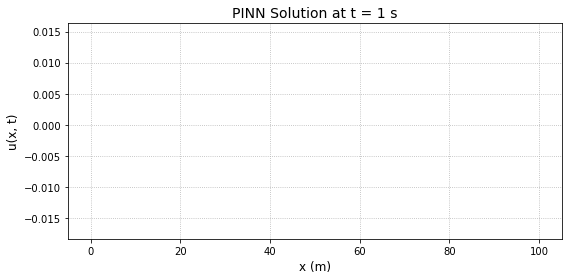

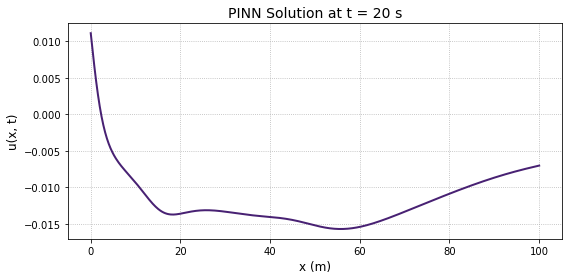

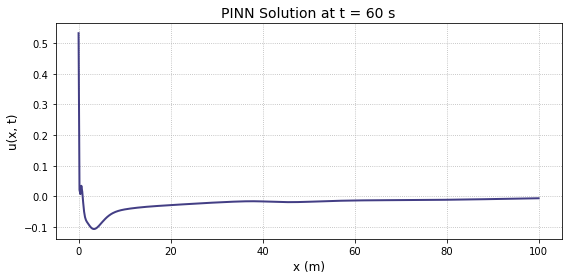

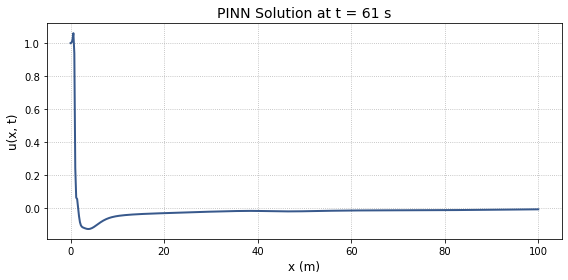

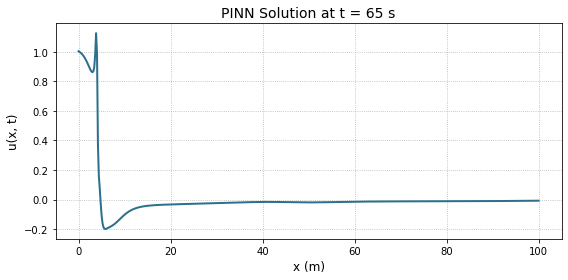

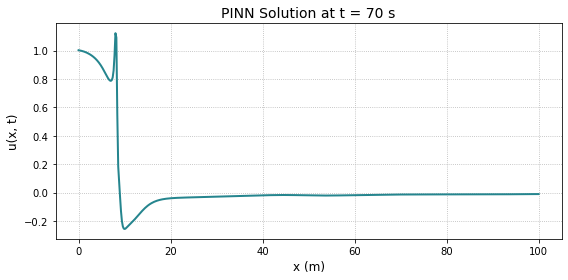

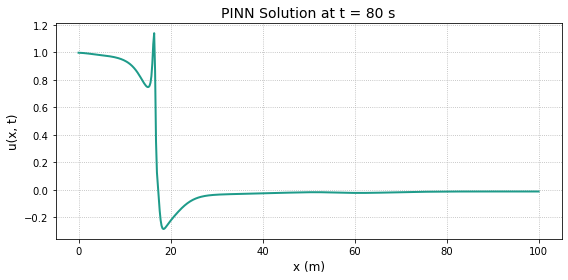

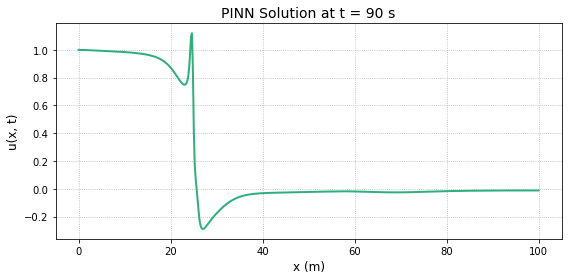

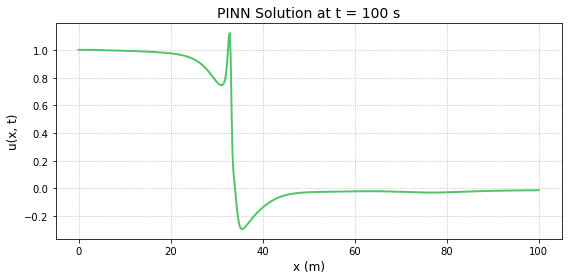

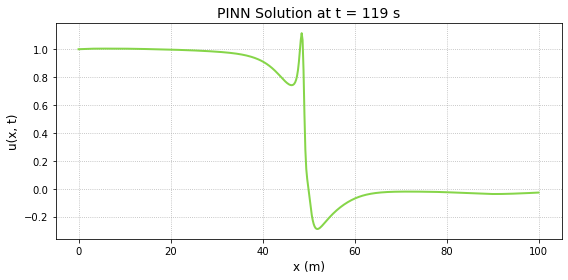

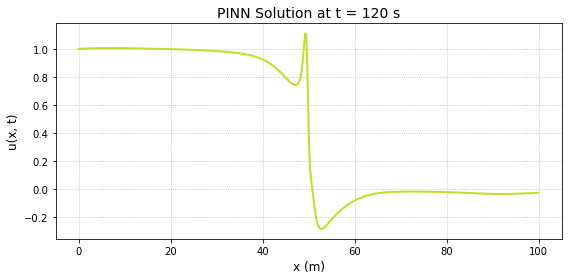

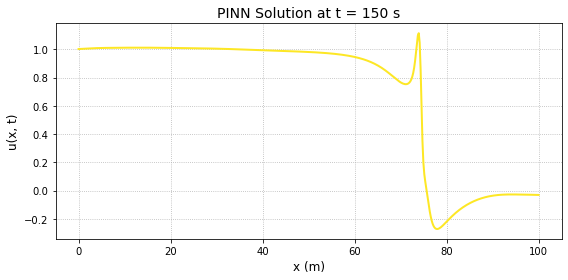

In [72]:
# -----------------------------------------------------------------------------
# Evaluation & Visualisation – separate line plots at each snapshot
# -----------------------------------------------------------------------------

import matplotlib.cm as cm

# Spatial grid for line plots
x_line = torch.linspace(0, Pipe_lenth, 500, device=device).view(-1, 1)

# Snapshot times
snapshot_times = torch.tensor([1, 20, 60, 61, 65, 70,80,90,100, 119, 120, 150], device=device)
colors = cm.viridis(torch.linspace(0.001, 1, len(snapshot_times)))

for idx, (t_val, color) in enumerate(zip(snapshot_times, colors)):
    t_line = t_val.expand_as(x_line)
    with torch.no_grad():
        u_pred_line = Mu(x_line, t_line).cpu().numpy().flatten()
    plt.figure(figsize=(8, 4))
    plt.plot(x_line.cpu().numpy().flatten(), u_pred_line, color=color, linewidth=2)
    plt.xlabel("x (m)", fontsize=12)
    plt.ylabel("u(x, t)", fontsize=12)
    plt.title(f"PINN Solution at t = {t_val.item():.0f} s", fontsize=14)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

In [73]:
torch.save(Mu.state_dict(), "Mu.pth")

In [ ]:
# -----------------------------------------------------------------------------
def compute_fd_from_functions(rho_fn, mu_fn, v, x, t, D, epsilon, a=1.0):
    """
    Compute Darcy friction factor f_D over a space-time mesh using input functions.

    Parameters:
        rho_fn (callable): function rho(x, t)
        mu_fn (callable): function mu(x, t)
        v_fn (callable): function v(x, t)
        x (torch.Tensor): 1D tensor of spatial points [nx]
        t (torch.Tensor): 1D tensor of time points [nt]
        D (float): pipe diameter
        epsilon (float): pipe roughness
        a (float): calibration factor

    Returns:
        fD_xt (torch.Tensor): [nx, nt] Darcy friction factor
    """
    X, T = torch.meshgrid(x, t, indexing='ij')  # [nx, nt] each

    # Evaluate rho, mu, v over the mesh
    rho_xt = rho_fn(X, T)
    mu_xt = mu_fn(X, T)
    

    # Compute Reynolds number
    Re = (rho_xt * V * D) / mu_xt
    fD_xt = torch.empty_like(Re)
    

    # Laminar regime
    laminar_mask = Re < 2000
    fD_xt[laminar_mask] = 64.0 / Re[laminar_mask]

    # Turbulent regime
    turbulent_mask = ~laminar_mask
    term = epsilon / (3.7 * D) + 5.74 / Re[turbulent_mask]**0.9
    fD_xt[turbulent_mask] = a * (torch.log10(term)) ** (-2)

    return fD_xt


In [ ]:
def F(v,Rho: nn.Module, x: torch.Tensor, t: torch.Tensor,D):

    rho = 1000*Rho(x,t)

    rho_x= rho.autograd.grad(rho, x,
                        grad_outputs=torch.ones_like(rho(x,t)),
                        create_graph=True)[0]
    rho_t= rho.autograd.grad(rho, t,
                        grad_outputs=torch.ones_like(rho(x,t)),
                        create_graph=True)[0]
    f_d= compute_fd_from_functions(rho, Mu, v, x, t, D, 2.13 * 1e-5, a=1.0)

    return (rho_t * v) (rho_x * v**2)+ (f_d * rho * v**2) / (2 * D)



In [94]:
# -----------------------------------------------------------------------------
# PINN for Pressure: dP/ds + F = 0
# -----------------------------------------------------------------------------

# Define the PINN architecture for pressure
pressure_layers = [2, 128, 128, 128, 1]  # Input: s, Output: P

class PressurePINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        blocks = []
        for l_in, l_out in zip(layers[:-2], layers[1:-1]):
            blocks.append(nn.Linear(l_in, l_out))
            blocks.append(nn.Tanh())
        blocks.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*blocks)
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, x, t):
        """x, t: tensors of shape (N,1)"""
        input_pair = torch.cat([x, t], dim=1)
        return self.model(input_pair)

In [95]:
Pressure= PressurePINN(pressure_layers).to(device)
opt_adam_pressure = torch.optim.Adam(Pressure.parameters(), lr=1e-3)
opt_lbfgs_pressure = torch.optim.LBFGS(Pressure.parameters(),
                              lr=1.0,
                              max_iter=1000,
                              tolerance_grad=1e-9,
                              tolerance_change=1e-9,
                              history_size=100,
                              line_search_fn="strong_wolfe")

In [96]:
# PDE residual: dP/ds + F = 0
def pressure_residual(model,x,t):
    x.requires_grad_(True)
    P = Pressure(x,t)
    P_x = autograd.grad(P, s, grad_outputs=torch.ones_like(P), create_graph=True)[0]
    F = F(a, rho, x, t, Pipe_diameter)
    return P_s + F

In [97]:
def loss_components():
    """Returns individual MSE losses: residual, IC, BC."""
    f = pde_residual(Pressure, x_f, t_f)
    Pressure_pred_i = Pressure(x_i, t_i)
    Pressure_pred_b = Pressure(x_b, t_b)
    # Compute the losses
    loss_f = torch.mean(f ** 2)
    loss_i = torch.mean((Pressure_pred_i - P_i) ** 2)
    loss_b = torch.mean((Pressure_pred_b - P_b) ** 2)
    # Return the losses
    return loss_f, loss_i, loss_b

In [98]:
# -----------------------------------------------------------------------------
# Stage 1 – Adam optimisation
# -----------------------------------------------------------------------------

epochs = 8000

for ep in range(epochs):
    opt_adam_pressure.zero_grad()
    lf, li, lb = loss_components()
    loss = lf + li + lb
    loss.backward()
    opt_adam_pressure.step()

    if ep % 500 == 0:
        print(f"Adam  {ep:4d}: total={loss.item():.3e}  "
              f"(res={lf.item():.1e}, IC={li.item():.1e}, BC={lb.item():.1e})")

# -----------------------------------------------------------------------------
# Stage 2 – L‑BFGS fine‑tuning
# -----------------------------------------------------------------------------

print("Starting L‑BFGS …")

def closure():
    opt_lbfgs_pressure.zero_grad()
    lf, li, lb = loss_components()
    loss = lf + li + lb
    loss.backward()
    return loss

opt_lbfgs_pressure.step(closure)
print("L‑BFGS complete.")


Adam     0: total=1.710e+00  (res=3.3e-04, IC=1.3e+00, BC=4.1e-01)
Adam   500: total=3.283e-05  (res=2.0e-05, IC=2.6e-06, BC=1.0e-05)
Adam  1000: total=1.036e-05  (res=6.5e-06, IC=2.1e-06, BC=1.8e-06)
Adam  1500: total=6.466e-06  (res=3.2e-06, IC=1.9e-06, BC=1.4e-06)
Adam  2000: total=4.847e-06  (res=1.9e-06, IC=1.7e-06, BC=1.3e-06)
Adam  2500: total=3.882e-06  (res=1.2e-06, IC=1.5e-06, BC=1.2e-06)
Adam  3000: total=3.327e-06  (res=9.0e-07, IC=1.3e-06, BC=1.1e-06)
Adam  3500: total=2.873e-06  (res=7.2e-07, IC=1.1e-06, BC=1.0e-06)
Adam  4000: total=2.491e-06  (res=6.1e-07, IC=9.9e-07, BC=8.9e-07)
Adam  4500: total=2.153e-06  (res=5.6e-07, IC=8.5e-07, BC=7.4e-07)
Adam  5000: total=2.500e-06  (res=5.4e-07, IC=7.4e-07, BC=1.2e-06)
Adam  5500: total=1.140e-05  (res=5.2e-07, IC=7.7e-07, BC=1.0e-05)
Adam  6000: total=1.199e-05  (res=5.0e-07, IC=6.7e-07, BC=1.1e-05)
Adam  6500: total=6.693e-06  (res=4.7e-07, IC=5.3e-07, BC=5.7e-06)
Adam  7000: total=9.342e-07  (res=4.0e-07, IC=3.7e-07, BC=1.7e

In [1]:
# -----------------------------------------------------------------------------
# Evaluation & Visualisation – separate line plots at each snapshot
# -----------------------------------------------------------------------------

import matplotlib.cm as cm

# Spatial grid for line plots
x_line = torch.linspace(0, Pipe_lenth, 500, device=device).view(-1, 1)

# Snapshot times
snapshot_times = torch.tensor([1, 20, 60, 61, 65, 70,80,90,100, 119, 120, 150], device=device)
colors = cm.viridis(torch.linspace(0.001, 1, len(snapshot_times)))

for idx, (t_val, color) in enumerate(zip(snapshot_times, colors)):
    t_line = t_val.expand_as(x_line)
    with torch.no_grad():
        u_pred_line = Pressure(x_line, t_line).cpu().numpy().flatten()
    plt.figure(figsize=(8, 4))
    plt.plot(x_line.cpu().numpy().flatten(), u_pred_line, color=color, linewidth=2)
    plt.xlabel("x (m)", fontsize=12)
    plt.ylabel("u(x, t)", fontsize=12)
    plt.title(f"PINN Solution at t = {t_val.item():.0f} s", fontsize=14)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

NameError: name 'torch' is not defined

In [ ]:
!nvidia-smi


Sat May 17 23:22:21 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:C1:00.0 Off |                    0 |
| N/A   27C    P0              72W / 500W |  78862MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [10]:
!kill -9 3400845


: 

: 

: 